In [1]:
import torch
from fastai.vision import *
from zipfile import ZipFile
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import io
from pathlib import Path
warnings.simplefilter("ignore")

## Data Bunching

In [2]:
from fastai.vision import *
path = Path('data/')
path.ls()
classes = ['noMask','withMask']
bs = 8
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train="data", valid_pct=0.2,
        ds_tfms=get_transforms(), size=128,bs=bs, num_workers=4).normalize(imagenet_stats)
data.classes

['noMask', 'withMask']

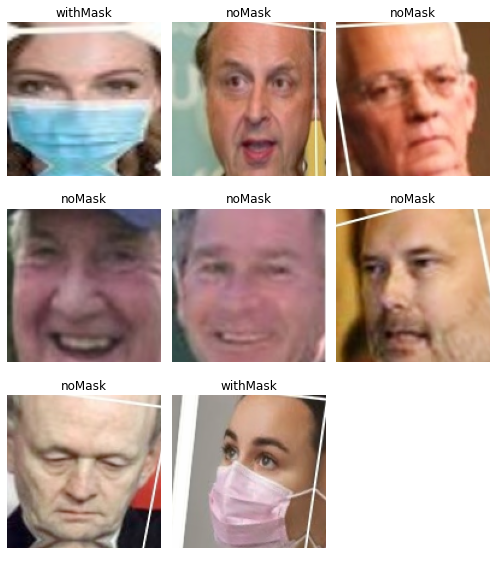

In [3]:
data.show_batch(rows=3, figsize=(7,8))

# Start Modeling

### Create Learner

In [4]:
import torchvision

learn = cnn_learner(data, models.resnet34, metrics=error_rate)

### Train

In [5]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.504760,0.178970,0.076613,00:58
1,0.313603,0.170170,0.072581,00:53
2,0.193318,0.079793,0.036290,00:55
3,0.159668,0.041387,0.012097,00:57
4,0.135985,0.065997,0.028226,00:57


In [7]:
learn.save('res34_stage1_1')

In [59]:
learn_mn.load('mn_stage1_1')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [17]:
learn.unfreeze()
#learn.lr_find(start_lr=1e-15, end_lr=1e-5)
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


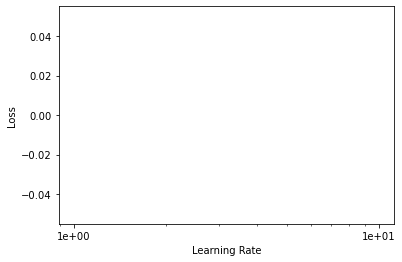

In [18]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.211841,0.058452,0.020161,01:00
1,0.197959,0.047487,0.000000,01:07
2,0.071758,0.006512,0.000000,01:09
3,0.046777,0.006433,0.000000,01:09


In [22]:
learn.save('res34_stage2_1')

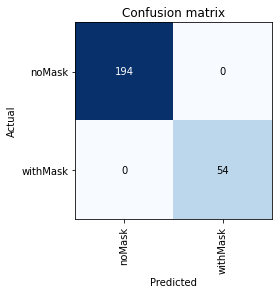

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#                                                    """"""""""""""""""""""""SavingModel"""""""""""""""""""

## 1. Method 1 - Manual changing of head

In [13]:
learn_mn.save('mn_stage2')  #Might not be saving dictionary here

In [100]:
#Open the fastai notebook you used for training and save the weights in the following unorthodox manner:
torch.save({'state_dict': learn_mn.model.state_dict()}, 'data/models/mn_dict.pth')
#torch.save(learn_mn.model.state_dict(), 'data/models/mn_dict.pth')

## 2. Method 2 - Load through FastAI 

In [19]:
learn_mn.export()

#                                                    """"""""""""""""""""""""Loading Model"""""""""""""""""""

## 1. Method 1 - Manual changing of head

## 2. Method 2 - Load through FastAI 

### Creating your data bunch



In [24]:
import torchvision
from fastai.vision import *
classes = ['noMask','withMask']
path = 'data'
data2 = ImageDataBunch.single_from_classes(path, classes, ds_tfms=get_transforms(), size=128).normalize(imagenet_stats)

learn = cnn_learner(data2, models.resnet34, metrics=error_rate)

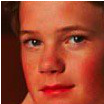

In [25]:
defaults.device = torch.device('cpu')
#img = open_image('D:/Projects/Mask Detector/misc/images/2.png')
img = open_image('D:/Projects/Mask Detector/misc/images/6.png')
img

In [26]:
    learn.load('res34_stage2_1');
# OR
#learn_mn = load_learner(path, file = 'export.pkl')

In [35]:
import time


tic= time.time() 
pred_class,pred_idx,outputs = learn.predict(img)
toc=time.time()
print(toc-tic)
pred_class



0.11308050155639648


Category noMask

## Testing Modules

### Capture a Photo or start a strem

In [7]:
import cv2
from imutils.video import VideoStream
import imutils
import time
import numpy as np

vs = VideoStream(src=1).start()
time.sleep(2.0)

def startstream():
    while True:
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord("q"):
            break

def capturephoto(vs):
    while(True):
        frame = vs.read()
        frame = imutils.resize(frame, width=400)
        cv2.imshow('img1',frame) #display the captured image
        if cv2.waitKey(1) & 0xFF == ord('y'): #save on pressing 'y' 
            cv2.imwrite('D:/Projects/Mask Detector/misc/images/c2.png',frame)
            cv2.destroyAllWindows()
            break
    vs.stream.release()
    
capturephoto(vs)

AttributeError: 'WebcamVideoStream' object has no attribute 'release'

### Crop Face and save

In [19]:
import os
import cv2
def facecrop(image):
    global i
    facedata = "haarcascade_frontalface_alt.xml"
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)
    if img.size == 0:
        print('no image')

    minisize = (img.shape[1],img.shape[0])
    miniframe = cv2.resize(img, minisize)
    print(minisize)
    
    faces = cascade.detectMultiScale(miniframe)

    for f in faces:
        i = i+1
        x, y, w, h = [ v for v in f ]
        cv2.rectangle(img, (x,y), (x+w,y+h), (255,255,255))

        sub_face = img[y:y+h, x:x+w]
        fname, ext = os.path.splitext(image)
        fname = os.path.split(image)
        save_dest = os.path.join(str(fname[0]),str(i)+ext)
        
        #cv2.imwrite(fname+"_cropped_"+ext, sub_face)
        cv2.imwrite(save_dest, sub_face)
        print(save_dest)
    return


In [21]:

i =1 
replace = False
plot = True

file_dir = 'D:/Projects/Mask Detector/misc/images'
for filename in os.listdir(file_dir):
    img_path  = os.fsdecode(filename)
    img_path = file_dir +'/'+ img_path
    print(img_path)
    if filename.endswith('.png'):
        
        #image = imageio.imread(img_path)
        facecrop(img_path)


D:/Projects/Mask Detector/misc/images/.ipynb_checkpoints
D:/Projects/Mask Detector/misc/images/1.jpg
D:/Projects/Mask Detector/misc/images/2.jpg
D:/Projects/Mask Detector/misc/images/3.jpg
D:/Projects/Mask Detector/misc/images/4.jpg
D:/Projects/Mask Detector/misc/images/adrian.png
(645, 584)
D:/Projects/Mask Detector/misc/images\2.png
D:/Projects/Mask Detector/misc/images\3.png
D:/Projects/Mask Detector/misc/images/c1.png
(400, 300)
D:/Projects/Mask Detector/misc/images\4.png
D:/Projects/Mask Detector/misc/images/c2.png
(400, 300)
D:/Projects/Mask Detector/misc/images\5.png
D:/Projects/Mask Detector/misc/images/neil_patrick_harris.png
(570, 389)
D:/Projects/Mask Detector/misc/images\6.png
D:/Projects/Mask Detector/misc/images/sachin.jpg
D:/Projects/Mask Detector/misc/images/samuel_l_jackson.png
(512, 512)
D:/Projects/Mask Detector/misc/images\7.png
